### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
#display all row in the data

def display_all(df):
    with pd.option_context('display.max_rows', None):
        with pd.option_context('display.max_columns', None):
            return display(df)

### Import Data

Import each given data and engineered data using pandas library :

In [3]:
app_test = pd.read_csv('./app_test.csv')
app_train = pd.read_csv('./app_train.csv')
ins_prev = pd.read_csv('./ins_prev.csv')

Checking LN_ID value_counts at ins_prev.csv :

In [4]:
ins_prev["LN_ID"].value_counts()

446486    62
238250    61
206862    60
133023    60
401563    59
          ..
142445     1
140396     1
443154     1
247711     1
276679     1
Name: LN_ID, Length: 72135, dtype: int64

There are multiple LN_IDs that have multiple values. Before ins_prev will be combined with app_train and app_test data, ins_prev will be grouped with LN_ID values so that one LN_ID only has one data.

In [5]:
#object columns
ins_prev_obj = ins_prev[ins_prev.dtypes[ins_prev.dtypes == "object"].index]
ins_prev_obj["LN_ID"] = ins_prev["LN_ID"]
ins_prev_obj.head()

#groupby LN_ID
ins_prev_obj = ins_prev_obj.groupby("LN_ID").agg(pd.Series.mode).reset_index()
ins_prev_obj

<ipython-input-5-68331f0963e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_prev_obj["LN_ID"] = ins_prev["LN_ID"]


,LN_ID,CONTRACT_TYPE,CONTRACT_STATUS,YIELD_GROUP
0,100009,Consumer loans,Approved,middle
1,100039,"[Cash loans, Consumer loans]",Approved,high
2,100044,Cash loans,Approved,middle
3,100045,Consumer loans,Approved,"[high, low_normal]"
4,100046,Cash loans,"[Approved, Refused]",low_normal
...,...,...,...,...
72130,456247,Consumer loans,Approved,low_normal
72131,456248,Cash loans,Approved,"[NA1, high, low_action, middle]"
72132,456249,"[Cash loans, Consumer loans]","[Approved, Refused]","[high, low_action]"
72133,456252,Consumer loans,Approved,low_normal


In [6]:
#for CONTRACT_TYPE column
for i in range(72135):
    if len(ins_prev_obj["CONTRACT_TYPE"].iloc[i]) < 5 :
        ins_prev_obj["CONTRACT_TYPE"].iloc[i] = ins_prev_obj["CONTRACT_TYPE"].iloc[i][0]
    else :
        ins_prev_obj["CONTRACT_TYPE"].iloc[i] = ins_prev_obj["CONTRACT_TYPE"].iloc[i][:]

#for CONTRACT_STATUS column
for i in range(72135):
    if len(ins_prev_obj["CONTRACT_STATUS"].iloc[i]) < 5 :
        ins_prev_obj["CONTRACT_STATUS"].iloc[i] = ins_prev_obj["CONTRACT_STATUS"].iloc[i][0]
    else :
        ins_prev_obj["CONTRACT_STATUS"].iloc[i] = ins_prev_obj["CONTRACT_STATUS"].iloc[i][:]

#for YIELD_GROUP column
for i in range(72135):
    if len(ins_prev_obj["YIELD_GROUP"].iloc[i]) < 6 :
        ins_prev_obj["YIELD_GROUP"].iloc[i] = ins_prev_obj["YIELD_GROUP"].iloc[i][0]
    else :
        ins_prev_obj["YIELD_GROUP"].iloc[i] = ins_prev_obj["YIELD_GROUP"].iloc[i][:]

#dealing with damaged values
ins_prev_obj["CONTRACT_TYPE"].replace("N","NA1",inplace=True)
ins_prev_obj["YIELD_GROUP"].replace("h","high",inplace=True)
ins_prev_obj["YIELD_GROUP"].replace("N","NA1",inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [7]:
#for weekdays_apply column
ins_prev_days = ins_prev[["LN_ID"]]
ins_prev_days["days_app"] = ins_prev["WEEKDAYS_APPLY"]
ins_prev_days

#change to number
def to_num_wrangler(row):
    if row['days_app'] == "MONDAY":
        return 0
    elif row['days_app'] == "TUESDAY":
        return 1
    elif row['days_app'] == "WEDNESDAY":
        return 2
    elif row['days_app'] == "THURSDAY":
        return 3
    elif row['days_app'] == "FRIDAY":
        return 4
    elif row['days_app'] == "SATURDAY":
        return 5
    elif row['days_app'] == "SUNDAY":
        return 6
    elif row['days_app'] == np.nan:
        return 8
    else:
        return 7
    
ins_prev_days['days_app'] = ins_prev_days.apply(lambda row: to_num_wrangler(row), axis=1)

#make new temporary dataframe
df = pd.DataFrame(ins_prev.LN_ID.unique(), columns = ['LN_ID'])
df["WEEKDAYS_APPLY"] = 1
df

#manually groupby with mode aggregate for weekdays_apply column
for i in range(72135):
    df["WEEKDAYS_APPLY"][i] = ins_prev_days[ins_prev_days["LN_ID"] == df.LN_ID.unique()[i]]["days_app"].mode()[0]
    
#change back to string
def to_string_wrangler(row):
    if row['WEEKDAYS_APPLY'] == 0:
        return "MONDAY"
    elif row['WEEKDAYS_APPLY'] == 1:
        return "TUESDAY"
    elif row['WEEKDAYS_APPLY'] == 2:
        return "WEDNESDAY"
    elif row['WEEKDAYS_APPLY'] == 3:
        return "THURSDAY"
    elif row['WEEKDAYS_APPLY'] == 4:
        return "FRIDAY"
    elif row['WEEKDAYS_APPLY'] == 5:
        return "SATURDAY"
    elif row['WEEKDAYS_APPLY'] == 6:
        return "SUNDAY"
    else:
        return np.nan
    
df['WEEKDAYS_APPLY'] = df.apply(lambda row: to_string_wrangler(row), axis=1)

df

<ipython-input-7-010388251529>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_prev_days["days_app"] = ins_prev["WEEKDAYS_APPLY"]
<ipython-input-7-010388251529>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_prev_days['days_app'] = ins_prev_days.apply(lambda row: to_num_wrangler(row), axis=1)


,LN_ID,WEEKDAYS_APPLY
0,271877,SATURDAY
1,176158,MONDAY
2,199383,THURSDAY
3,175704,SATURDAY
4,447712,FRIDAY
...,...,...
72130,415555,THURSDAY
72131,378593,SUNDAY
72132,102541,FRIDAY
72133,439792,MONDAY


In [8]:
#numerical columns
ins_prev_num = ins_prev.select_dtypes(include=['int64','float64'])
ins_prev_num.head()

#groupby LN_ID
ins_prev_num = ins_prev_num.groupby("LN_ID").agg("mean").reset_index()
ins_prev_num

,LN_ID,ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRICE,HOUR_APPLY,DAYS_DECISION,TERM_PAYMENT,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY
0,100009,10051.412143,76741.714286,70137.642857,9203.142857,76741.714286,13.714286,-719.285714,8.00,365243.0,-688.285714,51672.857143,0.000000,3.857143,-602.571429,-612.245238,10050.262714,10050.262714
1,100039,20679.495000,348917.523750,383785.875000,2.047500,465223.365000,14.000000,-1245.250000,18.00,365243.0,-1599.333333,-1442.333333,0.666667,3.303030,-1530.242424,-1549.709596,54125.121591,72009.584773
2,100044,18290.508750,288337.500000,299743.875000,1695.000000,288337.500000,14.250000,-1716.250000,24.00,365243.0,-1684.750000,-1195.000000,0.500000,9.256073,-1437.067814,-1453.367392,24605.021791,24007.083654
3,100045,18560.148750,339485.625000,368978.625000,1500.000000,339485.625000,14.000000,-1789.000000,18.00,365243.0,-1758.250000,-1324.500000,0.500000,8.205882,-1542.073529,-1546.637966,23432.586907,23035.015877
4,100046,28721.925000,393750.000000,481817.250000,NaN,393750.000000,14.000000,-494.000000,21.00,365243.0,-509.000000,365243.000000,1.000000,9.000000,-269.000000,-269.529412,28390.635000,28390.635000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72130,456247,10466.921250,59832.900000,59184.000000,2672.100000,59832.900000,12.200000,-1387.800000,7.75,365243.0,-1539.250000,-1390.250000,0.250000,3.375000,-1468.000000,-1476.600000,15322.235437,15322.235437
72131,456248,37444.038750,381240.000000,636604.875000,0.000000,508320.000000,14.750000,-1320.500000,10.50,365243.0,90198.000000,90493.000000,0.750000,7.500000,-1288.666667,-1291.836111,34910.977625,33788.665625
72132,456249,17133.952500,147105.000000,158699.250000,0.000000,147105.000000,9.500000,-1490.000000,12.00,365243.0,-1495.000000,-1156.000000,0.000000,6.500000,-1330.000000,-1332.500000,22771.410000,22771.410000
72133,456252,10074.465000,57595.500000,56821.500000,3456.000000,57595.500000,10.000000,-2497.000000,6.00,365243.0,-2466.000000,-2311.000000,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500


In [9]:
ins_prev = pd.merge(ins_prev_obj, ins_prev_num, on = 'LN_ID',
                    how = 'inner')
ins_prev = pd.merge(ins_prev, df, on = 'LN_ID',
                   how = 'inner')
ins_prev

,LN_ID,CONTRACT_TYPE,CONTRACT_STATUS,YIELD_GROUP,ANNUITY,APPLICATION,APPROVED_CREDIT,AMT_DOWN_PAYMENT,PRICE,HOUR_APPLY,...,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,INST_NUMBER,INST_DAYS,PAY_DAYS,AMT_INST,AMT_PAY,WEEKDAYS_APPLY
0,100009,Consumer loans,Approved,middle,10051.412143,76741.714286,70137.642857,9203.142857,76741.714286,13.714286,...,365243.0,-688.285714,51672.857143,0.000000,3.857143,-602.571429,-612.245238,10050.262714,10050.262714,WEDNESDAY
1,100039,Cash loans,Approved,high,20679.495000,348917.523750,383785.875000,2.047500,465223.365000,14.000000,...,365243.0,-1599.333333,-1442.333333,0.666667,3.303030,-1530.242424,-1549.709596,54125.121591,72009.584773,MONDAY
2,100044,Cash loans,Approved,middle,18290.508750,288337.500000,299743.875000,1695.000000,288337.500000,14.250000,...,365243.0,-1684.750000,-1195.000000,0.500000,9.256073,-1437.067814,-1453.367392,24605.021791,24007.083654,TUESDAY
3,100045,Consumer loans,Approved,high,18560.148750,339485.625000,368978.625000,1500.000000,339485.625000,14.000000,...,365243.0,-1758.250000,-1324.500000,0.500000,8.205882,-1542.073529,-1546.637966,23432.586907,23035.015877,FRIDAY
4,100046,Cash loans,Approved,low_normal,28721.925000,393750.000000,481817.250000,NaN,393750.000000,14.000000,...,365243.0,-509.000000,365243.000000,1.000000,9.000000,-269.000000,-269.529412,28390.635000,28390.635000,MONDAY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72130,456247,Consumer loans,Approved,low_normal,10466.921250,59832.900000,59184.000000,2672.100000,59832.900000,12.200000,...,365243.0,-1539.250000,-1390.250000,0.250000,3.375000,-1468.000000,-1476.600000,15322.235437,15322.235437,WEDNESDAY
72131,456248,Cash loans,Approved,NA1,37444.038750,381240.000000,636604.875000,0.000000,508320.000000,14.750000,...,365243.0,90198.000000,90493.000000,0.750000,7.500000,-1288.666667,-1291.836111,34910.977625,33788.665625,FRIDAY
72132,456249,Cash loans,Approved,high,17133.952500,147105.000000,158699.250000,0.000000,147105.000000,9.500000,...,365243.0,-1495.000000,-1156.000000,0.000000,6.500000,-1330.000000,-1332.500000,22771.410000,22771.410000,MONDAY
72133,456252,Consumer loans,Approved,low_normal,10074.465000,57595.500000,56821.500000,3456.000000,57595.500000,10.000000,...,365243.0,-2466.000000,-2311.000000,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500,WEDNESDAY


### Feature Engineering

Looking at the AMT_INST and AMT_PAY columns in **ins_prev.csv**, it can be seen that we can convert the two columns into one column with the aim of making the data simpler and showing which clients paid credits not according to the agreement.

If we look at the INST_DAYS and PAY_DAYS columns, we can also see that these two columns can be converted into one column in order to see which clients pay credit on time and which do not.

The code is as follows:


In [10]:
#Incorrect payment column
ins_prev["inc_payment"] = ins_prev["AMT_INST"] - ins_prev["AMT_PAY"]

#late payment column
ins_prev["late_payment"] = ins_prev["INST_DAYS"] - ins_prev["PAY_DAYS"]

#drop unecessary columns
ins_prev = ins_prev.drop(columns = ["AMT_INST", "AMT_PAY", "INST_DAYS", "PAY_DAYS"],
                        axis = 1)

Label Encoding :

LabelEncoding aims to convert a column with an object or category type into a number type so that the data can be used for machine learning models. In the ins_prev.csv data there are several columns to be encoded including **CONTRACT_TYPE**, **WEEKDAYS_APPLY**, **CONTRACT_STATUS** and **YIELD_GROUP**.

In [11]:
#define LabelEncoding for ins_prev.csv
label_enc_CONTRACT_TYPE = LabelEncoder()
label_enc_WEEKDAYS_APPLY = LabelEncoder()
label_enc_CONTRACT_STATUS = LabelEncoder()
label_enc_YIELD_GROUP = LabelEncoder()

#apply label encoder function (fit and transform)
ins_prev["CONTRACT_TYPE"] = label_enc_CONTRACT_TYPE.fit_transform(ins_prev["CONTRACT_TYPE"])
ins_prev["WEEKDAYS_APPLY"] = label_enc_WEEKDAYS_APPLY.fit_transform(ins_prev["WEEKDAYS_APPLY"])
ins_prev["CONTRACT_STATUS"] = label_enc_CONTRACT_STATUS.fit_transform(ins_prev["CONTRACT_STATUS"])
ins_prev["YIELD_GROUP"] = label_enc_YIELD_GROUP.fit_transform(ins_prev["YIELD_GROUP"])

In [12]:
#define LabelEncoding for loan.csv
label_enc_INCOME_TYPE = LabelEncoder()
label_enc_EDUCATION = LabelEncoder()
label_enc_FAMILY_STATUS = LabelEncoder()
label_enc_HOUSING_TYPE = LabelEncoder()
label_enc_ORGANIZATION_TYPE = LabelEncoder()
label_bin_GENDER = LabelBinarizer()

#apply encoding function to app_train.csv
app_train["INCOME_TYPE"] = label_enc_INCOME_TYPE.fit_transform(app_train["INCOME_TYPE"])
app_train["EDUCATION"] = label_enc_EDUCATION.fit_transform(app_train["EDUCATION"])
app_train["FAMILY_STATUS"] = label_enc_FAMILY_STATUS.fit_transform(app_train["FAMILY_STATUS"])
app_train["HOUSING_TYPE"] = label_enc_HOUSING_TYPE.fit_transform(app_train["HOUSING_TYPE"])
app_train["ORGANIZATION_TYPE"] = label_enc_ORGANIZATION_TYPE.fit_transform(app_train["ORGANIZATION_TYPE"])
app_train["GENDER"] = label_bin_GENDER.fit_transform(app_train["GENDER"])
app_train["CONTRACT_TYPE"] = label_enc_CONTRACT_TYPE.transform(app_train["CONTRACT_TYPE"])
app_train["WEEKDAYS_APPLY"] = label_enc_WEEKDAYS_APPLY.transform(app_train["WEEKDAYS_APPLY"])

#apply encoding function to app_test.csv
app_test["INCOME_TYPE"] = label_enc_INCOME_TYPE.transform(app_test["INCOME_TYPE"])
app_test["EDUCATION"] = label_enc_EDUCATION.transform(app_test["EDUCATION"])
app_test["FAMILY_STATUS"] = label_enc_FAMILY_STATUS.transform(app_test["FAMILY_STATUS"])
app_test["HOUSING_TYPE"] = label_enc_HOUSING_TYPE.transform(app_test["HOUSING_TYPE"])
app_test["ORGANIZATION_TYPE"] = label_enc_ORGANIZATION_TYPE.transform(app_test["ORGANIZATION_TYPE"])
app_test["GENDER"] = label_bin_GENDER.transform(app_test["GENDER"])
app_test["CONTRACT_TYPE"] = label_enc_CONTRACT_TYPE.transform(app_test["CONTRACT_TYPE"])
app_test["WEEKDAYS_APPLY"] = label_enc_WEEKDAYS_APPLY.transform(app_test["WEEKDAYS_APPLY"])

Combine train and test data into ins_prev data :

In [13]:
#train data
apptrain_new = pd.merge(app_train, ins_prev, on = 'LN_ID', 
                        how = 'left', suffixes = ('_NOW', '_PREV'))
display_all(apptrain_new.head())

,LN_ID,TARGET,CONTRACT_TYPE_NOW,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT_NOW,ANNUITY_NOW,PRICE_NOW,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY_NOW,HOUR_APPLY_NOW,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,CONTRACT_TYPE_PREV,CONTRACT_STATUS,YIELD_GROUP,ANNUITY_PREV,APPLICATION,APPROVED_CREDIT_PREV,AMT_DOWN_PAYMENT,PRICE_PREV,HOUR_APPLY_PREV,DAYS_DECISION,TERM_PAYMENT,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,INST_NUMBER,WEEKDAYS_APPLY_PREV,inc_payment,late_payment
0,333538,0,3,0,1,67500.0,202500.0,10125.0,202500.0,6,4,1,5,-11539,-921,-119.0,-2757,5,18,5,0.572805,0.608276,NaN,1.0,0.0,4.0,5378.7150,21955.500,19759.500,2196.0,21955.500,18.000000,-596.000000,4.00,365243.0,-550.00,-457.00,0.000,2.500000,1.0,0.000000,14.750000
1,406644,0,0,0,1,202500.0,976711.5,49869.0,873000.0,1,4,1,1,-15743,-4482,-1797.0,-2455,5,14,34,0.655600,0.684298,NaN,0.0,0.0,1.0,16864.4475,174600.000,212754.150,0.0,218250.000,12.000000,-682.100000,21.75,319538.0,-733.50,90801.50,0.875,5.599355,1.0,-2808.008036,7.725230
2,259130,0,0,0,0,180000.0,407520.0,25060.5,360000.0,2,4,1,1,-20775,365243,-8737.0,-4312,4,14,33,NaN,0.580687,0.749022,0.0,0.0,0.0,22977.1440,148528.500,318550.500,5868.0,222792.750,14.000000,-872.333333,9.60,365243.0,90475.25,-639.25,0.500,5.333333,0.0,0.000000,5.077778
3,411997,0,0,1,0,225000.0,808650.0,26086.5,675000.0,3,1,1,1,-20659,-10455,-4998.0,-4010,6,10,8,NaN,0.623740,0.710674,0.0,0.0,0.0,12012.7050,136906.875,149358.375,5625.0,136906.875,14.750000,-1356.250000,10.50,365243.0,90168.50,90465.00,0.500,7.696970,1.0,951.076364,5.356061
4,241559,0,3,1,0,135000.0,180000.0,9000.0,180000.0,1,4,3,1,-9013,-1190,-3524.0,-1644,3,11,7,0.175511,0.492994,0.085595,0.0,0.0,1.0,19100.1075,162619.500,170830.500,9210.0,162619.500,13.166667,-700.500000,11.00,365243.0,-716.60,-561.00,0.400,3.620000,6.0,562.117800,5.208333


In [14]:
#test data
apptest_new = pd.merge(app_test, ins_prev, on = 'LN_ID', 
                        how = 'left', suffixes = ('_NOW', '_PREV'))
display_all(apptest_new.head())

,LN_ID,TARGET,CONTRACT_TYPE_NOW,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT_NOW,ANNUITY_NOW,PRICE_NOW,INCOME_TYPE,EDUCATION,FAMILY_STATUS,HOUSING_TYPE,DAYS_AGE,DAYS_WORK,DAYS_REGISTRATION,DAYS_ID_CHANGE,WEEKDAYS_APPLY_NOW,HOUR_APPLY_NOW,ORGANIZATION_TYPE,EXT_SCORE_1,EXT_SCORE_2,EXT_SCORE_3,CONTRACT_TYPE_PREV,CONTRACT_STATUS,YIELD_GROUP,ANNUITY_PREV,APPLICATION,APPROVED_CREDIT_PREV,AMT_DOWN_PAYMENT,PRICE_PREV,HOUR_APPLY_PREV,DAYS_DECISION,TERM_PAYMENT,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,INST_NUMBER,WEEKDAYS_APPLY_PREV,inc_payment,late_payment
0,219092,0,0,1,3,135000.0,871029.0,44604.0,765000.0,6,4,1,1,-17598,-2650,-1411.0,-1131,2,7,5,NaN,0.145475,0.651260,0.0,0.0,0.0,8759.6250,36093.000000,37750.500000,7587.0,72186.000,11.333333,-878.500000,10.666667,365243.0,-1354.666667,-1170.000000,0.000000,4.100000,1.0,144.2625,11.633333
1,141577,0,0,0,0,144000.0,485640.0,34537.5,450000.0,6,1,1,3,-14097,-7408,-7908.0,-4872,1,14,28,NaN,0.682675,NaN,1.0,0.0,4.0,25746.5700,153130.500000,181314.000000,0.0,153130.500,17.000000,-1695.000000,8.000000,365243.0,-1664.000000,-1451.000000,0.000000,4.666667,1.0,2860.7300,6.333333
2,180205,0,0,0,1,90000.0,247500.0,8887.5,247500.0,6,4,1,1,-18384,-2826,-8226.0,-1930,2,12,43,0.814700,0.686312,0.758393,0.0,0.0,0.0,11169.7200,104490.000000,127153.125000,0.0,208980.000,13.000000,-1256.000000,12.000000,243074.0,-1616.000000,120880.333333,0.333333,13.833333,6.0,0.0000,5.085588
3,357381,0,0,1,2,112500.0,506889.0,24781.5,418500.0,6,4,1,1,-12170,-926,-916.0,-4048,4,13,34,0.399219,0.266520,0.058826,3.0,2.0,0.0,5779.6875,21683.863636,64638.409091,0.0,59630.625,10.363636,-251.545455,4.333333,365243.0,182416.500000,182570.500000,0.000000,6.461538,4.0,484.6500,7.769231
4,271229,0,0,1,0,216000.0,450000.0,21888.0,450000.0,6,2,1,1,-10790,-577,-4640.0,-2035,1,14,5,0.368452,0.610483,0.392774,0.0,0.0,0.0,12211.7700,49783.050000,126614.700000,8190.0,99566.100,11.200000,-471.400000,14.333333,273762.5,-636.250000,-446.000000,0.000000,4.500000,5.0,0.0000,7.171008


### Data Cleaning

Looking for Missing Data :

In [15]:
app_test.isna().values.any(), app_train.isna().values.any(), \
ins_prev.isna().values.any()

(True, True, True)

In [16]:
#define function to get missing values

def get_missing_value(df):
    mis_val = df.isnull().sum()
    tot_val = df.shape[0]
    mis_percentage = round((100 * mis_val / tot_val),
                           2)
    miss_tab = pd.concat([mis_val, mis_percentage], 
                         axis=1)
    miss_tab_col_name = miss_tab.rename(columns = {0 : 'Row With Missing Value', 
                                                   1 : 'Percentage (%)'})
    miss_tab_col_name = miss_tab_col_name.sort_values('Percentage (%)',ascending=False)
    return miss_tab_col_name[miss_tab_col_name["Row With Missing Value"] > 0]

In [17]:
get_missing_value(apptrain_new)

,Row With Missing Value,Percentage (%)
EXT_SCORE_1,34845,56.66
EXT_SCORE_3,12239,19.90
AMT_DOWN_PAYMENT,6816,11.08
INST_NUMBER,3633,5.91
late_payment,3635,5.91
inc_payment,3635,5.91
NFLAG_INSURED_ON_APPROVAL,3559,5.79
TERMINATION,3559,5.79
FIRST_DUE,3559,5.79
FIRST_DRAW,3559,5.79


In [18]:
get_missing_value(apptest_new)

,Row With Missing Value,Percentage (%)
EXT_SCORE_1,8312,56.31
EXT_SCORE_3,2919,19.78
AMT_DOWN_PAYMENT,1604,10.87
late_payment,881,5.97
inc_payment,881,5.97
INST_NUMBER,881,5.97
NFLAG_INSURED_ON_APPROVAL,868,5.88
TERMINATION,868,5.88
FIRST_DUE,868,5.88
FIRST_DRAW,868,5.88


Based on the **get_missing_value** function that has been called, it can be seen that the loss rate for each column is different, which ranges from 0.13 to 56 percent. For the first filtering, I'm going to delete the column with too many missing values because I'm afraid that if I engineer the column it will change the actual condition.

In [19]:
#deleting colomn with too much missing values (above 50%)
apptrain_new = apptrain_new.drop(columns = ["EXT_SCORE_1"], 
                                 axis = 1)
apptest_new = apptest_new.drop(columns = ["EXT_SCORE_1"], 
                                 axis = 1)

Dividing data into features data and target data :

In [20]:
#train data
X_train = apptrain_new.drop(columns = ["TARGET"], axis = 1)
y_train = apptrain_new["TARGET"]

#test data
X_test = apptest_new.drop(columns = ["TARGET"], axis = 1)
y_test = apptest_new["TARGET"]

Impute missing data using KNNImputer and scaling numeric data using StandardScaler :

In [21]:
for i in X_train.columns:
    X_train[i] = X_train[i].astype(np.uint8, errors = 'ignore')
    
for i in X_test.columns:
    X_test[i] = X_test[i].astype(np.uint8, errors = 'ignore')

In [22]:
#define scaler and imputer variable
knn_impute = KNNImputer()
SS = StandardScaler()

#scale and impute train data
X_train_scaled = pd.DataFrame(SS.fit_transform(X_train), 
                             columns = X_train.columns)
X_train_scaled_imputed = pd.DataFrame(knn_impute.fit_transform(X_train_scaled),
                                     columns = X_train_scaled.columns)

#scale and impute test data
X_test_scaled = pd.DataFrame(SS.transform(X_test), 
                             columns = X_test.columns)
X_test_scaled_imputed = pd.DataFrame(knn_impute.transform(X_test_scaled),
                                     columns = X_test_scaled.columns)

In [23]:
X_train_scaled_imputed

,LN_ID,CONTRACT_TYPE_NOW,GENDER,NUM_CHILDREN,INCOME,APPROVED_CREDIT_NOW,ANNUITY_NOW,PRICE_NOW,INCOME_TYPE,EDUCATION,...,DAYS_DECISION,TERM_PAYMENT,FIRST_DRAW,FIRST_DUE,TERMINATION,NFLAG_INSURED_ON_APPROVAL,INST_NUMBER,WEEKDAYS_APPLY_PREV,inc_payment,late_payment
0,1.335441,3.097847,-0.718858,0.820659,0.842227,-1.762623,-1.171933,-0.907296,0.946979,0.622593,...,0.560536,-1.247685,0.396303,-0.298342,-0.793858,-0.874348,-0.851122,-0.981682,0.089449,0.188091
1,-0.156584,-0.322805,-0.718858,0.820659,-1.616938,-0.872950,1.574641,0.911891,-1.304896,0.622593,...,0.411679,0.847039,-0.429633,-0.302980,0.035148,1.872396,-0.206324,-0.981682,-0.397861,-0.389735
2,-0.943288,-0.322805,-0.718858,-0.574663,-1.207077,1.158693,-0.139791,-0.479971,-0.854521,0.622593,...,0.082788,-0.586815,0.396303,2.002086,-0.795514,0.695220,-0.261668,-1.459369,0.089449,-0.607503
3,-0.468553,-0.322805,1.391094,-0.574663,1.720500,0.866561,-0.068887,0.374681,-0.404146,-1.691224,...,-0.753848,-0.480603,0.396303,1.994334,0.032091,0.695220,0.230069,-0.981682,0.254502,-0.584612
4,0.318151,3.097847,1.391094,-0.574663,-0.387356,-1.390819,-1.249678,-0.968343,-1.304896,0.622593,...,0.379868,-0.421597,0.396303,-0.302553,-0.794803,0.381306,-0.618114,1.406753,0.187001,-0.596764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,-1.418023,-0.322805,1.391094,2.215981,-0.738665,0.946233,1.204264,-0.235784,-0.404146,0.622593,...,0.757629,2.208399,-1.256173,-0.297989,0.037271,-0.874348,0.164615,0.929066,0.089449,-0.355158
61499,-1.295948,-0.322805,-0.718858,-0.574663,0.783676,-1.125245,0.785686,0.997356,-0.854521,0.622593,...,0.328520,1.395798,-1.807999,-0.303102,1.420371,1.218409,1.260752,-0.981682,0.092992,-0.788603
61500,-0.753394,3.097847,-0.718858,-0.574663,-1.616938,0.308855,1.238161,0.985147,-1.304896,-1.691224,...,0.009382,0.536272,0.396303,-0.306423,0.090768,-0.089564,0.200978,-0.408457,-0.393604,0.045513
61501,-0.034509,-0.322805,-0.718858,-0.574663,-1.148526,-0.965901,-0.661615,-0.479971,0.946979,0.622593,...,-0.689062,-0.618285,-1.264933,-0.337401,0.028276,0.695220,1.789643,0.929066,0.111366,-0.229320


In [24]:
X_train_scaled_imputed = X_train_scaled_imputed.drop(columns = ["LN_ID"],
                                                    axis = 1)
X_test_scaled_imputed = X_test_scaled_imputed.drop(columns = ["LN_ID"],
                                                    axis = 1)

In [25]:
X_train_scaled_imputed.isnull().values.any(), X_test_scaled_imputed.isnull().values.any()

(False, False)

### Feature Selection

##### Filter Method

In [26]:
#use SelectKBest
bestfeatures = SelectKBest(score_func = f_classif, k=10)
fit = bestfeatures.fit(X_train_scaled_imputed, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train_scaled_imputed.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(10,'Score'))  

            Feature        Score
19      EXT_SCORE_3  1628.579814
18      EXT_SCORE_2  1600.800292
21  CONTRACT_STATUS   291.971081
8         EDUCATION   218.543359
1            GENDER   217.968488
7       INCOME_TYPE   185.369583
29    DAYS_DECISION   153.550461
31       FIRST_DRAW   151.362147
6         PRICE_NOW   141.597604
22      YIELD_GROUP   109.455736


##### Embedded methods

<AxesSubplot:>

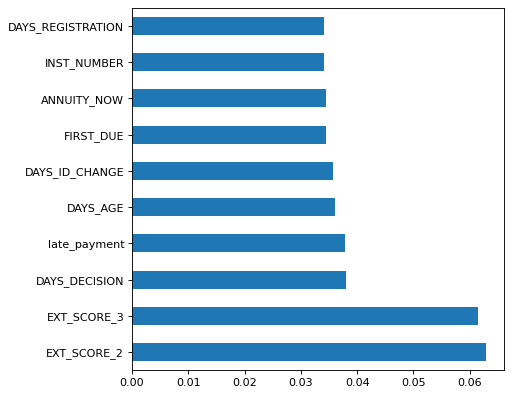

In [27]:
#Embedded Methods
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled_imputed, y_train)
feat_importances = pd.Series(rf_model.feature_importances_, 
                             index=X_train_scaled_imputed.columns)
df_imp_feat = feat_importances.nlargest(10)

#plotting feature importances
plt.figure(figsize=(6, 6), dpi=80)
df_imp_feat.plot(kind='barh')

Filtering features :

In [28]:
col = ['EXT_SCORE_3', 'EXT_SCORE_2', 'DAYS_AGE', 'CONTRACT_STATUS',
       'EDUCATION', 'GENDER', 'DAYS_ID_CHANGE', 'INCOME_TYPE',
       'DAYS_DECISION', 'DAYS_WORK', 'DAYS_ID_CHANGE', 'late_payment',
      'DAYS_REGISTRATION', 'FIRST_DUE', 'INST_NUMBER', 'PRICE_PREV']

In [29]:
X_train_final = X_train_scaled_imputed[col]
X_test_final = X_test_scaled_imputed[col]

In [30]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EXT_SCORE_3        61503 non-null  float64
 1   EXT_SCORE_2        61503 non-null  float64
 2   DAYS_AGE           61503 non-null  float64
 3   CONTRACT_STATUS    61503 non-null  float64
 4   EDUCATION          61503 non-null  float64
 5   GENDER             61503 non-null  float64
 6   DAYS_ID_CHANGE     61503 non-null  float64
 7   INCOME_TYPE        61503 non-null  float64
 8   DAYS_DECISION      61503 non-null  float64
 9   DAYS_WORK          61503 non-null  float64
 10  DAYS_ID_CHANGE     61503 non-null  float64
 11  late_payment       61503 non-null  float64
 12  DAYS_REGISTRATION  61503 non-null  float64
 13  FIRST_DUE          61503 non-null  float64
 14  INST_NUMBER        61503 non-null  float64
 15  PRICE_PREV         61503 non-null  float64
dtypes: float64(16)
memory 

### Dealing with Imbalanced Data

Let see target distribution, is it balanced or imbalanced? If it's imbalanced, data should be analyzed further.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0.5, 'Target Count'),
 Text(0.5, 1.0, 'TARGET Distribution (Train Data)')]

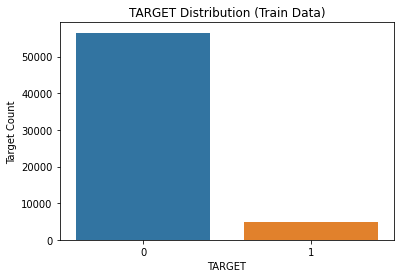

In [31]:
ax = sns.countplot(apptrain_new["TARGET"])
ax.set(ylabel='Target Count', 
        title='TARGET Distribution (Train Data)')

In [32]:
#resample data using SMOTE

sm = SMOTE(random_state = 0)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_final.values, y_train)

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_final.columns)

In [33]:
X_train_resampled

,EXT_SCORE_3,EXT_SCORE_2,DAYS_AGE,CONTRACT_STATUS,EDUCATION,GENDER,DAYS_ID_CHANGE,INCOME_TYPE,DAYS_DECISION,DAYS_WORK,DAYS_ID_CHANGE,late_payment,DAYS_REGISTRATION,FIRST_DUE,INST_NUMBER,PRICE_PREV
0,-0.270238,0.492336,1.488778,-0.339259,0.622593,-0.718858,-0.944205,0.946979,0.560536,-0.495981,-0.944205,0.188091,0.109466,-0.298342,-0.851122,-0.896843
1,0.010151,0.889927,0.026590,-0.339259,0.622593,-0.718858,-0.320499,-1.304896,0.411679,-0.168110,-0.320499,-0.389735,1.652016,-0.302980,-0.206324,0.128097
2,1.224615,0.348048,1.218002,-0.339259,0.622593,-0.718858,-1.201823,-0.854521,0.082788,0.701462,-1.201823,-0.607503,1.273144,2.002086,-0.261668,0.151817
3,1.027496,0.573214,-0.677426,-0.339259,-1.691224,1.391094,-0.578117,-0.404146,-0.753848,-1.379808,-0.578117,-0.584612,-0.093502,1.994334,0.230069,-0.296631
4,-2.185637,-0.110582,1.028460,-0.339259,0.622593,1.391094,0.262531,-1.304896,0.379868,-0.681299,0.262531,-0.596764,-0.932433,-0.302553,-0.618114,-0.162374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113063,0.352420,0.609229,0.092023,-0.339259,0.622593,-0.718858,-0.766489,0.946979,-0.180096,0.998324,-0.766489,-0.984297,0.648435,-0.309378,-0.323204,-0.459698
113064,0.261389,0.946227,0.385009,-0.339259,0.622593,1.391094,1.407541,0.946979,0.596718,0.270806,1.407541,-0.568566,-1.334441,-0.301969,0.022803,1.169835
113065,-1.212201,-1.405204,-1.034172,1.603558,-0.939228,-0.718858,0.035424,0.913210,0.802438,0.869323,0.035424,-0.532522,0.754899,-0.314107,1.531648,2.491576
113066,-0.183986,0.826154,-0.294850,-0.339259,-1.691224,-0.718858,1.286887,0.946979,0.467368,-1.325550,1.286887,0.961749,0.764639,-0.300029,-0.904818,-0.278879


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0.5, 'Target Count'),
 Text(0.5, 1.0, 'TARGET Distribution (Train Data)')]

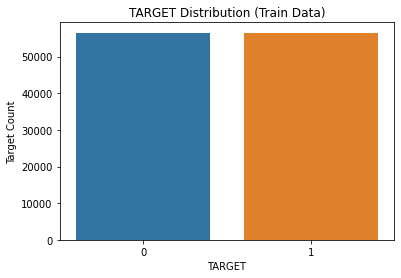

In [34]:
#checking distribution again
ax = sns.countplot(y_train_resampled)
ax.set(ylabel='Target Count', 
        title='TARGET Distribution (Train Data)')

### Convert to .CSV

In [36]:
#train data
X_train_resampled.to_csv('X_train_resampled.csv', index = False)
y_train_resampled.to_csv('y_train_resampled.csv', index = False)

#test data
X_test_final.to_csv('X_test_final.csv', index = False)
y_test.to_csv('y_test.csv', index = False)

#train data before resampled
X_train_final.to_csv('X_train_final.csv', index = False)
y_train.to_csv('y_train_final.csv', index = False)